# Lab 4: Block Cipher

## Task 1: Implementing PRESENT

In [ ]:
##!/usr/bin/env python3

# Present skeleton file for 50.042 FCS


# constants
FULLROUND = 31

# S-Box Layer
"""
S-box layer is not derived from a mathematical formula. Instead, it was designed based on several security guidelines
"""
sbox = [0xC, 0x5, 0x6, 0xB, 0x9, 0x0, 0xA, 0xD, 0x3, 0xE, 0xF, 0x8, 0x4, 0x7, 0x1, 0x2]

# PLayer
pmt = [
    0,
    16,
    32,
    48,
    1,
    17,
    33,
    49,
    2,
    18,
    34,
    50,
    3,
    19,
    35,
    51,
    4,
    20,
    36,
    52,
    5,
    21,
    37,
    53,
    6,
    22,
    38,
    54,
    7,
    23,
    39,
    55,
    8,
    24,
    40,
    56,
    9,
    25,
    41,
    57,
    10,
    26,
    42,
    58,
    11,
    27,
    43,
    59,
    12,
    28,
    44,
    60,
    13,
    29,
    45,
    61,
    14,
    30,
    46,
    62,
    15,
    31,
    47,
    63,
]

inv_sbox = [
    0x5,
    0xE,
    0xF,
    0x8,
    0xC,
    0x1,
    0x2,
    0xD,
    0xB,
    0x4,
    0x6,
    0x3,
    0x0,
    0x7,
    0x9,
    0xA,
]

# Inverse of PRESENT pLayer
inv_pmt = [0] * 64
for index, item in enumerate(pmt):
    inv_pmt[item] = index


# Rotate left: 0b1001 --> 0b0011
def rol(val: hex, r_bits: int, max_bits: int) -> hex:
    """
    This functions takes in a binary value and shifts left
    e.g. 0b1001 --> 0b0011
    """
    return (val << r_bits % max_bits) & (2**max_bits - 1) | (
        (val & (2**max_bits - 1)) >> (max_bits - (r_bits % max_bits))
    )


# Rotate right: 0b1001 --> 0b1100
def ror(val: hex, r_bits: int, max_bits: int) -> hex:
    return ((val & (2**max_bits - 1)) >> r_bits % max_bits) | (
        val << (max_bits - (r_bits % max_bits)) & (2**max_bits - 1)
    )


def genRoundKeys(key: int) -> list[int]:
    """
    Input: 80-bit hexadecimal key\n
    Output: list with 33 round keys
    """
    # Step 0: Define a key register & an array to store the round keys
    keyReg = key & ((1 << 80) - 1)
    roundKeys = []

    for roundNumber in range(33):

        # Step 1.1: extract the leftmost 64-bits of the key register
        currentRoundKey = keyReg >> 16
        print(f"{roundNumber}:{currentRoundKey}")

        # Step 1.2: append it into the list
        roundKeys.append(currentRoundKey)

        if roundNumber < 32:
            # Step 2.1: rotate the key register to the left by 61-bits
            keyReg = rol(keyReg, 61, 80)

            # Step 2.2: substitute the top 4-bits of the key register using S-Box
            top4Bits = (keyReg >> 76) & 0xF
            new4Bits = sBoxNibble(top4Bits)

            # Step 2.3: put it back into the key register
            # first, we need to clear the top 4-bits from the key register first
            # create a mask
            mask = ~(0xF << 76)
            # bitwise AND with the key register
            keyReg &= mask
            # now we can insert it back into the key register using bitwise OR
            keyReg |= (new4Bits & 0xF) << 76

            # Step 3: XOR the current round number into bits 19 - 15 of the key register
            rNum = (roundNumber + 1) & 0x1F  # <-- makes sure round number is 5-bits
            keyReg ^= rNum << 15

    return roundKeys


def addRoundKey(state, Ki):
    return state ^ Ki


def sBoxLayer(state: int) -> int:
    """
    Substitutes the state with the mapping defined, sbox
    """
    result = 0
    for i in range(16):
        nibble = (state >> (i * 4)) & 0xF
        substituted = sbox[nibble]
        result |= substituted << (i * 4)
    return result


def sBoxNibble(state: int) -> int:
    return sbox[state]


def pLayer(state):
    """
    Routes every bit in the 64-bit state to another position based
    on the permutation table
    """
    result = 0
    for i in range(64):
        currentBit = (state >> i) & 1
        result |= currentBit << pmt[i]
    return result


def inv_sBoxLayer(state: int) -> int:
    result = 0
    for i in range(16):
        nibble = (state >> (i * 4)) & 0xF
        result |= inv_sbox[nibble] << (i * 4)
    return result


def inv_pLayer(state: int) -> int:
    result = 0
    for i in range(64):
        bit = (state >> i) & 1
        result |= bit << inv_pmt[i]
    return result


def present_round(state, roundKey):
    state = addRoundKey(state, roundKey)
    state = sBoxLayer(state)
    state = pLayer(state)
    return state


def present_inv_round(state, roundKey):
    state = inv_pLayer(state)
    state = inv_sBoxLayer(state)
    state = addRoundKey(state, roundKey)
    return state


def present(plain, key):
    K = genRoundKeys(key)
    state = plain
    for i in range(1, FULLROUND + 1):
        state = present_round(state, K[i])
    state = addRoundKey(state, K[32])
    return state


def present_inv(cipher, key):
    K = genRoundKeys(key)
    state = cipher
    state = addRoundKey(state, K[32])
    for i in range(FULLROUND, 0, -1):
        state = present_inv_round(state, K[i])
    return state


if (
    __name__ == "__main__"
):  # <-- only run this code if the file is ran directly, not as a module
    # Testvector for key schedule
    key1 = 0x00000000000000000000
    keys = genRoundKeys(key1)
    keysTest = {
        0: 32,
        1: 0,
        2: 13835058055282163712,
        3: 5764633911313301505,
        4: 6917540022807691265,
        5: 12682149744835821666,
        6: 10376317730742599722,
        7: 442003720503347,
        8: 11529390968771969115,
        9: 14988212656689645132,
        10: 3459180129660437124,
        11: 16147979721148203861,
        12: 17296668118696855021,
        13: 9227134571072480414,
        14: 4618353464114686070,
        15: 8183717834812044671,
        16: 1198465691292819143,
        17: 2366045755749583272,
        18: 13941741584329639728,
        19: 14494474964360714113,
        20: 7646225019617799193,
        21: 13645358504996018922,
        22: 554074333738726254,
        23: 4786096007684651070,
        24: 4741631033305121237,
        25: 17717416268623621775,
        26: 3100551030501750445,
        27: 9708113044954383277,
        28: 10149619148849421687,
        29: 2165863751534438555,
        30: 15021127369453955789,
        31: 10061738721142127305,
        32: 7902464346767349504,
    }
    # for k in keysTest.keys():
    #     assert keysTest[k] == keys[k]

    # Testvectors for single rounds without keyscheduling
    plain1 = 0x0000000000000000
    key1 = 0x00000000000000000000
    round1 = present_round(plain1, key1)
    round11 = 0xFFFFFFFF00000000
    assert round1 == round11

    round2 = present_round(round1, key1)
    round22 = 0xFF00FFFF000000
    assert round2 == round22

    round3 = present_round(round2, key1)
    round33 = 0xCC3FCC3F33C00000
    assert round3 == round33

    # invert single rounds
    plain11 = present_inv_round(round1, key1)
    assert plain1 == plain11
    plain22 = present_inv_round(round2, key1)
    assert round1 == plain22
    plain33 = present_inv_round(round3, key1)
    assert round2 == plain33

    # Everything together
    plain1 = 0x0000000000000000
    key1 = 0x00000000000000000000
    cipher1 = present(plain1, key1)
    plain11 = present_inv(cipher1, key1)
    assert plain1 == plain11

    plain2 = 0x0000000000000000
    key2 = 0xFFFFFFFFFFFFFFFFFFFF
    cipher2 = present(plain2, key2)
    plain22 = present_inv(cipher2, key2)
    assert plain2 == plain22

    plain3 = 0xFFFFFFFFFFFFFFFF
    key3 = 0x00000000000000000000
    cipher3 = present(plain3, key3)
    plain33 = present_inv(cipher3, key3)
    assert plain3 == plain33

    plain4 = 0xFFFFFFFFFFFFFFFF
    key4 = 0xFFFFFFFFFFFFFFFFFFFF
    cipher4 = present(plain4, key4)
    plain44 = present_inv(cipher4, key4)
    assert plain4 == plain44

    print("All's correct!")


## Task 2: Encrypting / Decrypting image

### Encrypted Image

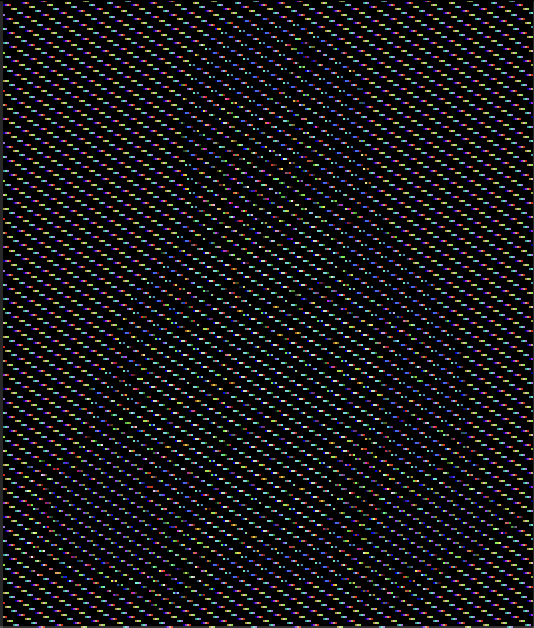

### Decrypted Image

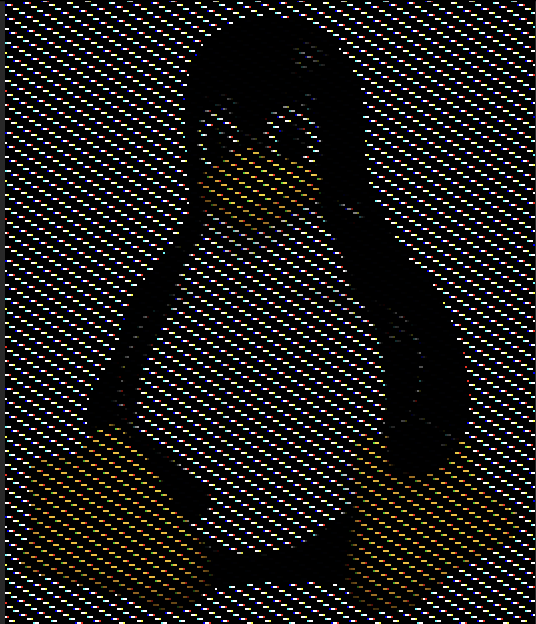

## Task 3: Limitations of ECB

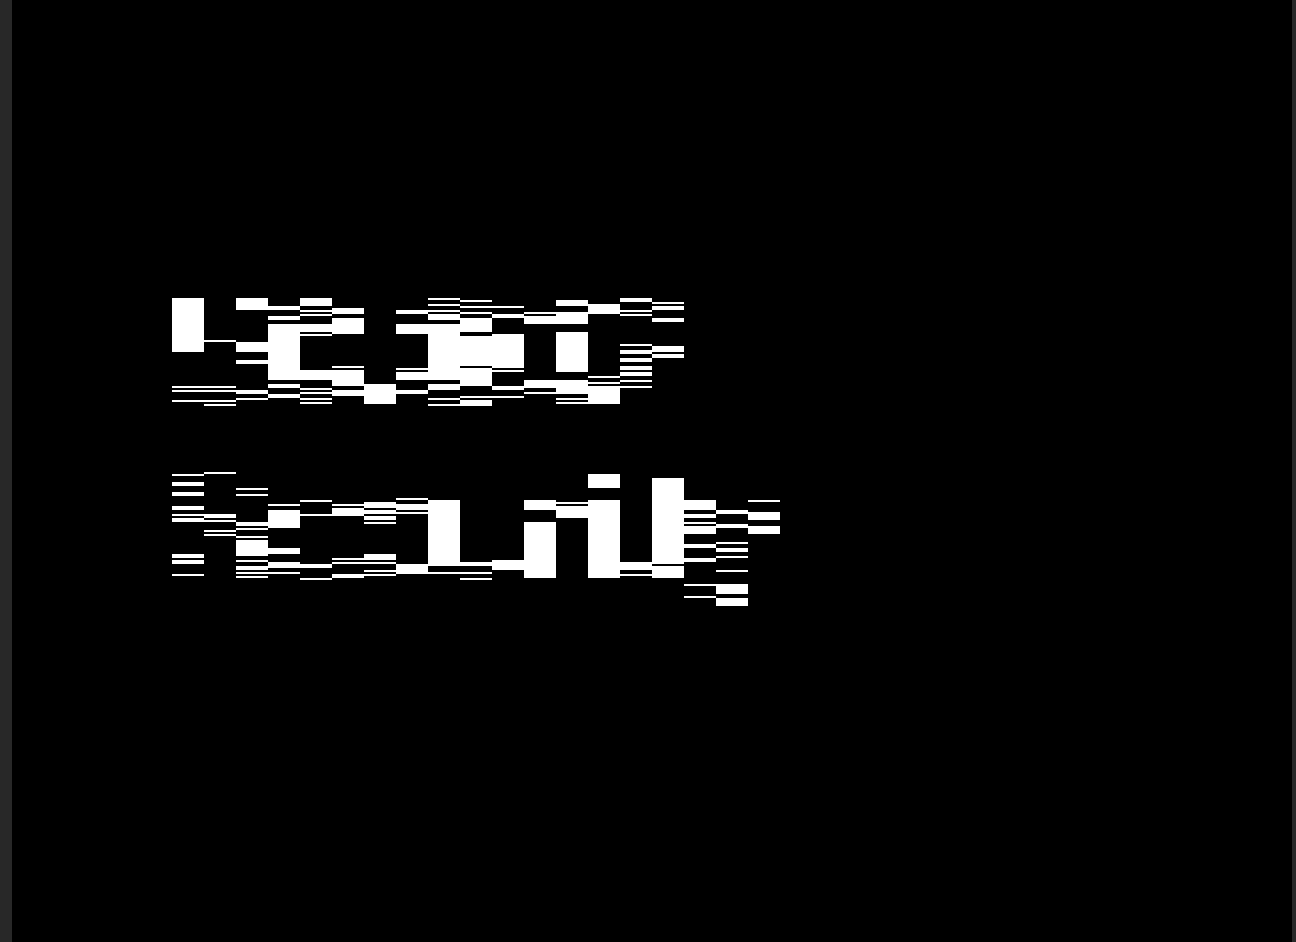